In [1]:
# pip install keras-tuner

## Essential libraries and modules.

This project uses the following modules/libraries. <br>
- datetime, shutil, os for files and system operations
- Pandas and numpy for data manipulation.
- sklearn.model_selection, sklearn.metrics for machine learning and model evaluation.
- matplotlib.pyplot and seaborn (sns) for visualization.
- tensorflow.keras APIs and modules for building and training the CNN model.
- keras_tuner for optimizing the model's hyperparameters.
- random to maintain reproducibility of experiments.

In [2]:
from datetime import datetime
import shutil
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from kerastuner import HyperModel
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners  import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from keras_tuner import HyperModel

import torch
import random

# Set randomness for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


/var/folders/mn/l_yfj1_57wj54hlcqkxgxysh0000gn/T/ipykernel_31993/2943324566.py:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


## Load data

We first load the classification data from a CSV file into a pandas DataFrame and set the directory path for the associated images. <br>
The CSV file, named "**classifications.csv**" includes two key columns; **image_filename**, which lists the names of image files, and **bethesda_system**, which contains image labels categorized into the following six classes: 
- ASC-US - Negative for intraepithelial lesion.
- ASC-H - Atypical squamous cells of undetermined significance.
- LSIL - Atypical squamous cells cannot exclude HSIL.
- HSIL - Low grade squamous intraepithelial lesion.
- SCC - High grade squamous intraepithelial lesion. <br>
    
The images corresponding to these classifications are stored separately in a directory named "**images**".

In [3]:
# Load dataset
data_path = 'data/classifications.csv'
data = pd.read_csv(data_path)

# Directory where images are stored
image_dir = 'data/images/'


## Explore Class Distribution <br>

We explored the bethesda_system column which contains the image labels to check data distribution. <br>

The original class distribution appears to be highly imbalanced, with the "**Negative for intraepithelial lesion**" category dominating the dataset. <br>

To address this imbalance and reduce potential model bias, a **resampling technique** was applied, resulting in a uniform distribution of classes. <br>

The side-by-side bar plots visually demonstrate the results of the resampling technique in achieving class balance, an essential step in ensuring our CNN model will generalize well across all classes.


Original Class Distribution:
Negative for intraepithelial lesion    6779
HSIL                                   1703
LSIL                                   1360
ASC-H                                   925
ASC-US                                  606
SCC                                     161
Name: bethesda_system, dtype: int64

Resampled Class Distribution:
SCC                                    6779
Negative for intraepithelial lesion    6779
LSIL                                   6779
HSIL                                   6779
ASC-H                                  6779
ASC-US                                 6779
Name: bethesda_system, dtype: int64


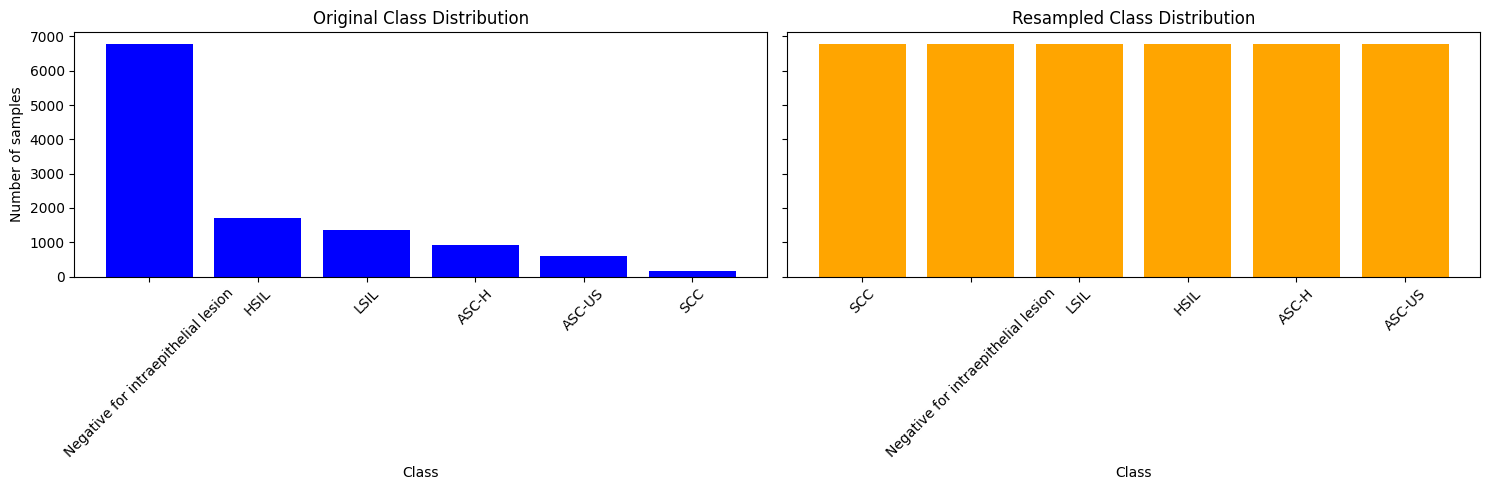

In [4]:
# Calculate the class distribution for the original dataset
original_class_distribution = data['bethesda_system'].value_counts()

# Display Original class distribution counts
print("Original Class Distribution:")
print(original_class_distribution)

# Oversample all classes to the count of the majority class
max_size = original_class_distribution.max()

lst = [data]
for class_index, group in data.groupby('bethesda_system'):
    lst.append(group.sample(max_size-len(group), replace=True))
resampled_data = pd.concat(lst)

# Calculate the class distribution for the resampled dataset
resampled_class_distribution = resampled_data['bethesda_system'].value_counts()

# Display resampled class distribution counts
print("\nResampled Class Distribution:")
print(resampled_class_distribution)


# Class distributions before and after resampling
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

# Original class distribution plot
axs[0].bar(original_class_distribution.index, original_class_distribution.values, color='blue')
axs[0].set_title('Original Class Distribution')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Number of samples')
axs[0].tick_params(axis='x', rotation=45)

# Resampled class distribution plot
axs[1].bar(resampled_class_distribution.index, resampled_class_distribution.values, color='orange')
axs[1].set_title('Resampled Class Distribution')
axs[1].set_xlabel('Class')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



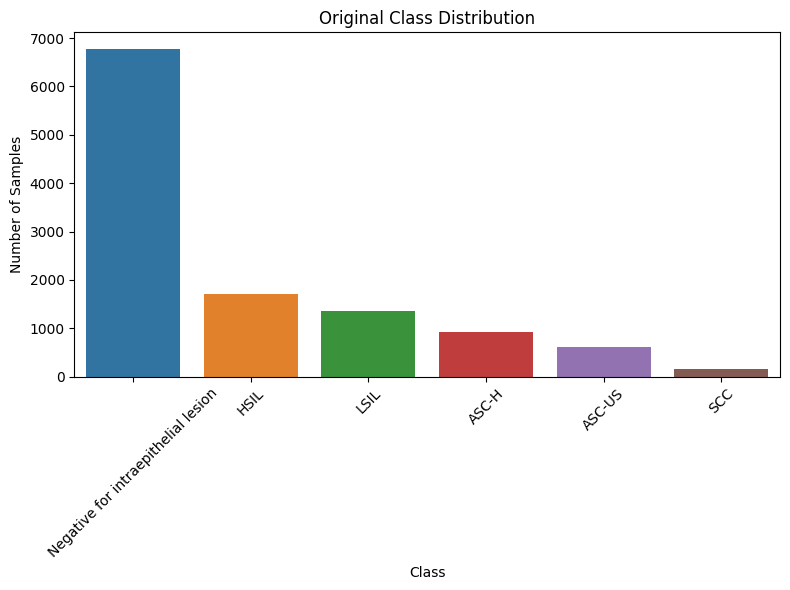

In [29]:
# Original class distribution plot for reporting purpose.
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.barplot(x=original_class_distribution.index, y=original_class_distribution.values)
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)  # Rotate class labels for better visibility
plt.tight_layout()
plt.show()

## Split data

The resampled dataset is initially partitioned into a training and a test set using an 80/20 split. <br>
This means 80% of the data is used for training the model, and the remaining 20% is set aside to test the model's performance on unseen data. <br>
The **train_test_split function** from the **sklearn.model_selection module** is used with a **random_state** set to 42 to ensure reproducibility of the split. <br>

The training set is further divided into a new training set and a validation set, using 80/20 split. <br>
The validation set is used during the model training process to evaluate the model's performance on a subset of data that it hasn't been trained on, allowing for hyperparameter tuning and prevention of overfitting. <br>
The random_state is kept consistent at 42 for this split as well, maintaining the same level of reproducibility.


In [5]:
# Split the data into training and test set using 80/20 ratio
train_df, test_df = train_test_split(resampled_data, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets (80/20 split)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

print("train_df:", train_df.shape)
print("\ntest_df:", test_df.shape)
print("\nval_df:", val_df.shape)

train_df: (26031, 7)

test_df: (8135, 7)

val_df: (6508, 7)


## Data preprocessing

The pixel values of images for training, validation, and testing are normalized by rescaling them by 1./255, which changes the pixel's range from [0, 255] to [0, 1]. This step is necessary for effective training as it helps in faster convergence of the model. <br>

We already split the dataset into separate training, validation and test sets. <br>

The **flow_from_dataframe** method of the **ImageDataGenerator** class is used to load image paths and labels from a pandas DataFrame, with images stored on the disk. This method creates a pipeline that feeds image data in batches to the CNN model directly from the disk, enhancing memory efficiency during model training. <br>

The training and validation generators feeds the images in batches to the CNN model during the fit process, allowing us to validate the CNN model on the validation subset during the training phase. <br>

The test generator is set up similarly but without shuffling, to maintain the order of the images, which is crucial for the evaluation phase to ensure correspondence between the predicted outputs and the true labels. <br>

The main goal of this section is to establish an efficient pipeline that dynamically loads batches of image data directly from the disk into the model, reducing memory overhead, normalizing images to facilitate training, and setting aside data for model validation and testing.


In [6]:
# Modify image target size
image_target_size = (75, 75)

# Initialize ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)

# Validation Data Generator
validation_datagen = ImageDataGenerator(rescale=1./255)

# Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)


# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='image_filename',
    y_col='bethesda_system',
    target_size=image_target_size,
    batch_size=128,
    class_mode='categorical'
)

# Validation generator
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='image_filename',
    y_col='bethesda_system',
    target_size=image_target_size,
    batch_size=128,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='image_filename',
    y_col='bethesda_system',
    target_size=image_target_size,
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

Found 26031 validated image filenames belonging to 6 classes.
Found 6508 validated image filenames belonging to 6 classes.
Found 8135 validated image filenames belonging to 6 classes.


## Defining CNN Model

The **CNNHyperModel** class encapsulates the architecture of the CNN model for the purpose of hyperparameter optimization using Keras Tuner. The class extends the **HyperModel** class from **Keras Tuner**, allowing the definition of a range of hyperparameters to be selected during the tuning process.

The **input_shape** attribute specifies the dimensions of the input images that the CNN will process, and essentially used to configure the input layer of the network.

The **num_classes** variable indicates the total number of distinct classes that the model will predict, used in the output layer to determine the size of the softmax distribution across these classes. <br>

The **build** method dynamically constructs the CNN model with its architecture defined by hyperparameters which are determined during the tuning phase. <br>

**Model Architecture:** <br>
**Convolutional Layers:** The first convolutional layer defines number of filters ranging from 16 to 64. Three additional convolutional layers that double in filter count, capped at 128. The kernel size for these layers is fixed at 3×3, and the activation function is chosen from ['relu', 'tanh']. <br>

**Pooling Layers:** For each convolutional layer except the last, the model has a max pooling layer with a pool size of 2×2 which serves to downsample the feature maps, reducing the computational complexity and helping to mitigate overfitting. <br>

**Flattening:** The Flatten layer converts the 2D feature maps into a 1D feature vector, making it possible to connect convolutional layers to dense layers. <br>

**Dense Layer:** A dense or fully connected layer with a tunable number of units (ranging from 64 to 256) follows, which learns global patterns from the flattened feature vectors. <br>

**Dropout:** A Dropout layer with a tunable rate (between 0.3 and 0.7) is used to reduce overfitting by randomly setting a fraction of input units to 0 at each update during training. <br>

**Output Layer:** The final layer is a dense layer with units equal to the number of output classes and uses the softmax activation function to yield a probability distribution over these classes. <br>

**Compilation:** <br>
The model is compiled with the Adam optimizer, and a learning rate that undergoes logarithmic sampling between 0.0001 and 0.01 for optimization. <br>

The model uses **categorical_crossentropy** loss function because we are dealing with multi-class classification problem. <br>

**accuracy** metric is used to evaluate the overall model performance. <br>

The structured approach allows evaluation of different hyperparameter combinations to optimize model performance.

In [8]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def build(self, hp):
        model = Sequential()
        
        # Input layer to define the input shape
        model.add(Input(shape=self.input_shape)) 
        
        # First convolutional layer
        filters = hp.Int('initial_filters', min_value=16, max_value=64, step=16)
        model.add(Conv2D(filters=filters, kernel_size=(3, 3), activation=hp.Choice('activation', ['relu', 'tanh']), padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

        # Three Additional convolutional layers
        for i in range(2, 5):
            filters *= 2
            filters = min(filters, 128)
            model.add(Conv2D(filters=filters, kernel_size=(3, 3), activation=hp.Choice('activation', ['relu', 'tanh']), padding='same'))
            if i < 4:
                model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(BatchNormalization())

        # Flattening to a 1D vector
        model.add(Flatten())
        
        # Dense layer
        model.add(Dense(units=hp.Int('units', min_value=64, max_value=256, step=64), activation=hp.Choice('activation', ['relu', 'tanh'])))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)))
        
        # Output layer
        model.add(Dense(self.num_classes, activation='softmax'))
        
        # Compile the model
        model.compile(
            optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model


## Hyperparameters tuning

This section ocovers the hyperparameter tuning process for the CNN model. <br>
The essential variables are difined which include; the number of steps per epoch, the maximum number of trials, and the number of epochs for training. <br>
The CNNHyperModel class is instantiated with the resized input shape of the images of 75×75 pixels with 3 channels (RGB), and the number of output classes derived from the training data generator which is equivalent to 6. <br>

A **RandomSearch** tuner is initialized with the objective set to maximize validation accuracy. The serach is limited to a single trial (**max_trial = 1**). This can be increased, but this leads to higher execution time. Each trial executes once (**executions_per_trial=1**) to find the best model configuration within the defined search space. <br>

The **EarlyStopping** callback is used to stop the training if the validation loss does not improve for five consecutive epochs (**patience=5**), enhancing computational efficiency and preventing overfitting. <br>

The **tuner.search** method then executes the tuning process, utilizing the training and validation data generators, and follows to the predefined number of steps per epoch. <br>

The best hyperparameters shows that the optimal configuration in this single trial consists of 64 initial filters, relu activation function, 256 dense layer units, a dropout rate of 0.4, and a learning rate of approximately 0.00028. <br>

The hyperparameter tuning directory **hyperparam_tuning** is cleared for each tuning session to avoid conflicts with previous tuning results. Additionally, the project name, dynamically generated with a timestamp, ensures uniqueness and ease of result retrieval for each session.




In [9]:
# Variables 
no_steps_per_epoch = 64
max_trial = 1
epoch = 10

# Use timestamp to create a unique project name for each search session
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
project_name = f"cervix_classification_{timestamp}"

# Clear the hyperparameter tuning directory for each session
tuning_dir = 'hyperparam_tuning'
if os.path.exists(tuning_dir):
    shutil.rmtree(tuning_dir)
    
# Define the hypermodel
hypermodel = CNNHyperModel(input_shape=(75, 75, 3), num_classes=len(train_generator.class_indices))

# Initialize the tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=max_trial,
    executions_per_trial=1,
    directory=tuning_dir,
    project_name=project_name
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Perform hyperparameter tuning
tuner.search(train_generator, 
             epochs=epoch, 
             validation_data=validation_generator,
             steps_per_epoch=no_steps_per_epoch)

# Fetch the best performing hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameter values
print("\nBest Hyperparameters : \n")
for hp in best_hps.space:
    print(f"{hp.name}: {best_hps.get(hp.name)}")



Trial 1 Complete [01h 35m 28s]
val_accuracy: 0.6150891184806824

Best val_accuracy So Far: 0.6150891184806824
Total elapsed time: 01h 35m 28s

Best Hyperparameters : 

initial_filters: 64
activation: relu
units: 256
dropout: 0.4
learning_rate: 0.00028228483297071025


## Training the Best Model 

After hyperparameter tuning, the best hyperparameters are applied to rebuild the optimal model, train the model on the full training set and validate the model agaimnst the validation data set for 10 epochs. <br>

This section is responsible for constructing and training the CNN model using the best hyperparameters obtained from the previous hyperparameter tuning phase. <br>
The **tuner.hypermodel.build** function is used to create the model with the optimal hyperparameters. The he model is then trained using the fit method on the training data for 10 epochs. <br>
The **train_generator** provides the training data in batches, and the **validation_generator** evaluates the model's performance on the validation data after each epoch.

Initially, the model's accuracy on the training set improves substantially from around 61% to nearly 79% by the end of the 10 epochs. However, the validation accuracy starts very low at around 17% and only begins to significantly improve after the ninth epoch, reaching approximately 62% in the tenth epoch. The validation loss decreases accordingly. <br>

This output suggests a few points of interest:

- The model is learning and improving its performance on the training set across epochs as indicated by increasing accuracy and decreasing loss.
- There is a significant discrepancy between training and validation performance in the initial epochs, suggesting overfitting, where the model learns the training data very well but fails to generalize to the validation data.
- The validation metrics improve later in the training, which could indicate that the model required more iterations to generalize or that the validation set is challenging and may not represent the training set distribution well.
- Considering the late improvement on the validation set, the model could potentially benefit from:
    - Further training beyond the 10 epochs.
    - Further tuning of dropout rates
    - Addition of regularization.
    - Augmentation of the training data.

The Augmentation option didn't help out and thereefore not an option to consider at this stage.

In [10]:
epoch = 10
# Build the model with the optimal hyperparameters and train it on the data for given epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_generator, epochs=epoch, validation_data=validation_generator, steps_per_epoch=no_steps_per_epoch)


Epoch 1/10


2024-04-08 22:47:40.796634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 2 of 8
2024-04-08 22:47:51.774611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-08 22:48:02.761057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 6 of 8
2024-04-08 22:48:13.737043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 684s 10s/step - accuracy: 0.6102 - loss: 1.3187 - val_accuracy: 0.1721 - val_loss: 2.0882
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 626s 10s/step - accuracy: 0.7466 - loss: 0.6989 - val_accuracy: 0.1721 - val_loss: 3.4658
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 614s 10s/step - accuracy: 0.7685 - loss: 0.6536 - val_accuracy: 0.1661 - val_loss: 3.4870
Epoch 4/10
12/64 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.7777 - loss: 0.6316

2024-04-08 23:19:36.053845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/ReadVariableOp_7/_7]]
2024-04-08 23:19:36.054271: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3973345711687893286
2024-04-08 23:19:36.054498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-08 23:19:36.054515: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1852568335499034647
2024-04-08 23:19:36.054712: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2513848702048567612
2024-04-08 23:19:36.054720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 3

64/64 ━━━━━━━━━━━━━━━━━━━━ 284s 5s/step - accuracy: 0.7737 - loss: 0.5853 - val_accuracy: 0.1868 - val_loss: 2.8579
Epoch 5/10


2024-04-08 23:24:28.603970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 2 of 8
2024-04-08 23:24:39.628188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-08 23:24:50.654913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 6 of 8
2024-04-08 23:25:01.722872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 676s 10s/step - accuracy: 0.7680 - loss: 0.6329 - val_accuracy: 0.1938 - val_loss: 3.7018
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 622s 10s/step - accuracy: 0.7814 - loss: 0.5917 - val_accuracy: 0.1985 - val_loss: 3.9307
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 610s 10s/step - accuracy: 0.7714 - loss: 0.5874 - val_accuracy: 0.3328 - val_loss: 2.3699
Epoch 8/10
12/64 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - accuracy: 0.7609 - loss: 0.6312

2024-04-08 23:56:09.038541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-08 23:56:09.039204: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3973345711687893286
2024-04-08 23:56:09.039230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/ReadVariableOp_13/_21]]
2024-04-08 23:56:09.039248: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1852568335499034647
2024-04-08 23:56:09.039424: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2513848702048567612
2024-04-08 23:56:09.039432: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash:

64/64 ━━━━━━━━━━━━━━━━━━━━ 283s 4s/step - accuracy: 0.7621 - loss: 0.5799 - val_accuracy: 0.2982 - val_loss: 2.0948
Epoch 9/10


2024-04-09 00:00:59.897252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 2 of 8
2024-04-09 00:01:10.828538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 4 of 8
2024-04-09 00:01:21.768669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 6 of 8
2024-04-09 00:01:32.768905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 672s 10s/step - accuracy: 0.7727 - loss: 0.6010 - val_accuracy: 0.5187 - val_loss: 1.2464
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 623s 10s/step - accuracy: 0.7891 - loss: 0.5590 - val_accuracy: 0.6185 - val_loss: 0.8454


## Learning Curves

**Training and Validation Accuracy**

The Training Accuracy curve shows a relatively stable and high accuracy, indicating that the model is fitting well to the training data. <br>
In contrast, the Validation Accuracy curve begins at a significantly lower value, suggesting that the model is not initially performing well on the validation set. However, from around the **seventh epoch**, there is a notable increase in validation accuracy, implying that the model starts to generalize better to new data. <br>

**Training and Validation Loss**

The Training Loss decreases steadily, which shows the model is learning from the training data. <br>
The Validation Loss shows varying fluctuations intially, and after the peak at around the fifth epoch, there is a marked downward trend, aligning with the improvement seen in the validation accuracy. <br>

The discrepancy between training and validation accuracy, especially in the initial epochs, suggests overfitting. However, the subsequent improvement in validation accuracy and reduction in validation loss indicates that the model is starting to generalize better as training progresses. <br>

The high variability in the validation loss curve can be a sign of a small validation set, leading to larger swings in loss values, or it could be indicative of the model learning a complex pattern from the training data that initially did not translate well to the validation data. <br>


This calls for further investigation into the model regularization techniques e.g L1/L2 regularization, to mitigate the overfitting seen in the initial epochs. <br>

Given the late improvement in validation metrics, extending the number of training epochs might allow the model to continue to learn and potentially improve validation performance further. <br>

Image rotation, zooming image, horizontal and vertical flips are some of the augmentation strategies tested but did not show an improvement in generalization. <br>

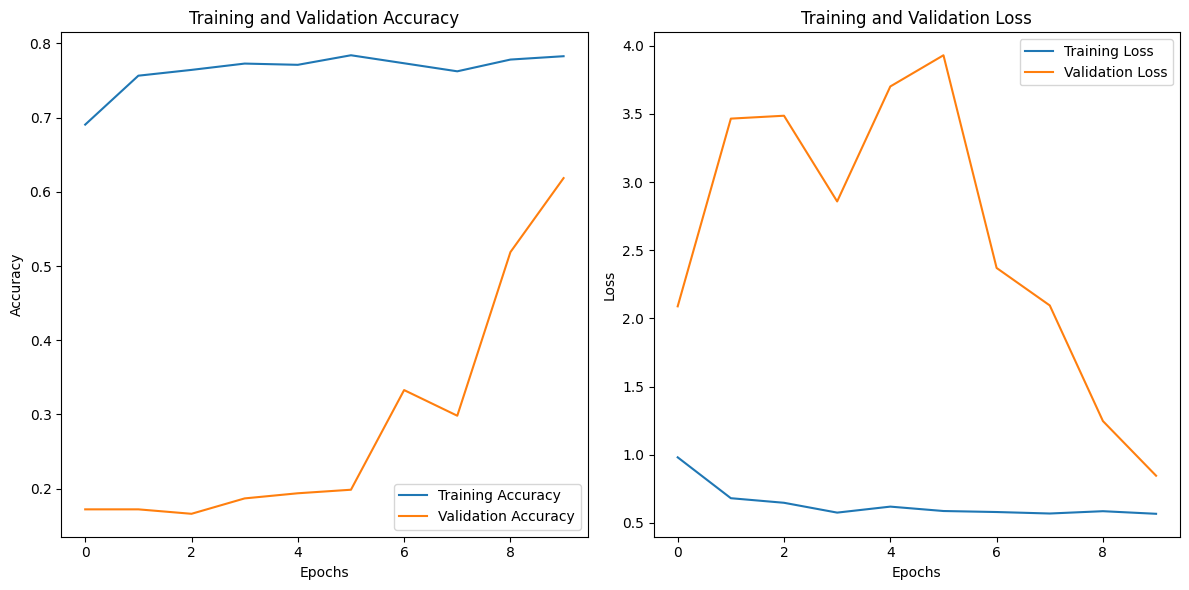

In [11]:
# Plot the loss curves
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The **history.history** dictionary contains training/validation results. <br>
We create a DataFrame to display the results. <br>


In [12]:
# Convert history.history dictionary to a DataFrame a
df_history = pd.DataFrame(history.history).reset_index().rename(columns={'index': 'epoch'})

# Adjust the 'epoch' column to start from 1 to represent epoch numbers accurately
df_history['epoch'] += 1 # Since Index start at 0, we add 1 to represent epoch values.

df_history


,epoch,accuracy,loss,val_accuracy,val_loss
0,1,0.690544,0.980291,0.172096,2.088238
1,2,0.756470,0.680366,0.172096,3.465767
2,3,0.764282,0.646777,0.166103,3.486965
3,4,0.772786,0.574651,0.186847,2.857947
4,5,0.771118,0.618614,0.193762,3.701753
5,6,0.783997,0.586339,0.198525,3.930675
6,7,0.773193,0.578938,0.332821,2.369895
7,8,0.762370,0.568053,0.298248,2.094825
8,9,0.778198,0.585015,0.518746,1.246428
9,10,0.782715,0.565966,0.618470,0.845362


In [13]:
# Find the record with the minimum val_loss
min_val_loss = df_history.loc[df_history['val_loss'].idxmin()]

print("The best performing results: \n")
print(f"Epoch : {int(min_val_loss.epoch)}")
print(f"Training Accuracy : {min_val_loss.accuracy:.4f}")
print(f"Training Loss : {min_val_loss.loss:.4f}")
print(f"Validation Accuracy : {min_val_loss.val_accuracy:.4f}")
print(f"Validation Loss : {min_val_loss.val_loss:.4f}")


The best performing results: 

Epoch : 10
Training Accuracy : 0.7827
Training Loss : 0.5660
Validation Accuracy : 0.6185
Validation Loss : 0.8454


## Model Evaluation on test set

Evaluating the model's performance on a separate test set is necessary to ensure that the late improvement in validation performance observed with the accuracy curves translates to genuine predictive power on unseen data. <br>

The model achieves a test accuracy of 61.22% which is close to the validation accuracy of 61.84%. Even though the accuracy moderate, the close performance between test and validation test confirms the model's generalization capability on new unseen data. <br>

The test loss is reported to be 0.8462 compared to validation loss of 0.8454. This value represents the model's average error over the test dataset and corresponds to the loss function used during the model's training/validation phase.


In [14]:
# Let's evaluate the model on test data
eval_result = model.evaluate(test_generator)
print("Model performance on Test Dataset : \n")
print(f'Test Accuracy : {eval_result[1]:.4f}')
print(f'Test Loss : {eval_result[0]:.4f}')


/Users/jmware/.pyenv/versions/3.10.9/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 349s 5s/step - accuracy: 0.6144 - loss: 0.8413
Model performance on Test Dataset : 

Test Accuracy : 0.6122
Test Loss : 0.8462


## Predict classes on test set

In [15]:
# Let's do class predictions on the test set
test_generator.reset()  # To restart the generator from the beginning
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 


64/64 ━━━━━━━━━━━━━━━━━━━━ 349s 5s/step


## Confusion Matrix

The confusion matrix helps us to compare the actual target values with those predicted by the model. Generally, for a well-performing model, the majority of predictions are expected to be along the diagonal, indicating correct classifications.

**Class Mapping Summary:** <br>
- ASC-H: 0
- ASC-US: 1
- HSIL: 2
- LSIL: 3
- Negative for intraepithelial lesion: 4
- SCC: 5

Classes 1, 2 and 0 have the highest correct predictions, with prominent diagonal elements of **1243**, **1111** and **1023** respectively. <br>

The off-diagonal numbers in the matrix reflect instances where the model has predicted the incorrect class. Majority of the classes have a considerable number of instances misclassified as Class 1, with Class 3 having the highest number of classifications (728 instances). This indicates a potential overlap in features or insufficiently learned representations or suggesting similarities between these classes that the model struggles to differentiate. <br>


Confusion Matrix:
[[1023  244    2    0   52    3]
 [  15 1243    5   14   35    8]
 [   7  187 1111   16   22   44]
 [  43  728   38  344  221   15]
 [  46  630   21   18  648    1]
 [  54  533   10  143    0  611]]


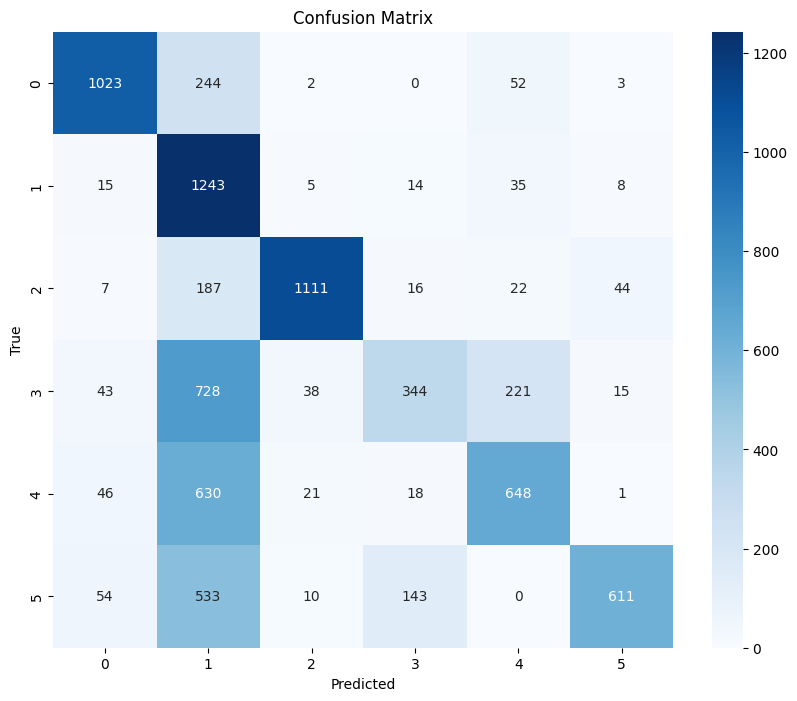

In [30]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

# Visualization of confusion matrix

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

## Classification Report

The per-class metrics exposed by the classification report helps to assess the model performance. <br>

**Precision** indicates the accuracy of positive predictions for each class. Class 2 (HSIL) and Class 5 (SCC) have high precision, which means that when the model predicts these classes, it is correct most of the time. <br>

**Recall** reflects the ability of the model to find all the positive samples. Class 1 (ASC-US) has the highest recall, suggesting that the model is adept at identifying this class. <br>

**F1-score** which is a weighted average of precision and recall, reaches its best value at 1 (perfect precision and recall) and worst at 0. Class 2 (HSIL) has the highest F1-score, indicating a balanced recall and precision for this class. <br>


In [17]:
# Classification Report
cr = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print("Classification Report:")
print(cr)

Classification Report:
                                     precision    recall  f1-score   support

                              ASC-H       0.86      0.77      0.81      1324
                             ASC-US       0.35      0.94      0.51      1320
                               HSIL       0.94      0.80      0.86      1387
                               LSIL       0.64      0.25      0.36      1389
Negative for intraepithelial lesion       0.66      0.48      0.55      1364
                                SCC       0.90      0.45      0.60      1351

                           accuracy                           0.61      8135
                          macro avg       0.72      0.62      0.62      8135
                       weighted avg       0.73      0.61      0.62      8135



## Conclusion

The overall accuracy of the model is 0.61, matching the test accuracy reported at the evaluation stage. <br>
The model performs well for certain classes (e.g., Class 2), but struggles with others (Class 1, Class 3, and Class 4), which could be due to class overlap in the feature space. <br>

The high recall for Class 1 may be at the cost of low precision, indicating a large number of false positives. <br>

Future strategies to improve model performance could include: <br>
- Collecting more data.
- Feature engineering like different data augmentation techniques.
- Using class weights to address imbalance.
- Exploring other models to better capture the differences between classes.
- Consider regularization techniques e.g L1/L2 regularization.